<h1>Anomaly Detection thanks to <i>Unsupervised Learning</i></h1>
<br>
<img src='images/0.jpg'>

We are going to some train models that will be either able to reproduce the probability density function of a specific data-generating process or to identify whether a given new sample is an <i><b>inlier</b></i> or an <i><b>outlier</i></b>. What these models aim to do is finding and returning anomalies. These anomalies are samples that are below or under a predefined threshold, this threshold is given by a probability distribution $p(x) << \lambda$ where $\lambda$ is the predefined threshold or quite far from the centroid of the main distribution.
<br>
<br>
In this notebook we are going to develop and understand the next parts:
<ul>
    <li>Saying hello to Probability Density Functions.</li>
    <li>Histograms are not enought, but why?</li>
    <li>Kernel Density Estimation (KDE).</li>
    <li>Selection criteria with Bandwidth.</li>
    <li>Univariate Anomaly Detection.</li>
    <li>Anomaly Detection with HTTP Attacks.</li>
    <li>One-class Support Vector Machines.</li>
    <li>Isolation Forests for Anomaly Detection.</li>
    <li>Summary.</li>
</ul>
<br>
Let's start learning! First's we are going to define some vocabulary for simplicity and understand better the topics of Probability Densities:
<ul>
    <li>$P(X)$ means <i>Probability of $x$</i>.</li>
    <li>$p(x)$ means <i>Density of $x$</i>.</li>
    <li>$m = min(X)$, it is the minimum value of the set $X$. It can also 
        mean number of sample of set $X$.</li>
    <li>$M = max(X)$, it is the maximum value of the set $X$.</li>
    <li>$K(\bullet)$ its meaning is a kernel function.</li>
    <li>$\bar{w}$ weights of a vector.</li>
    <li>$\xi$ Slack variable, for bringing flexibility.</li>
    <li>$\rho$ Threshold for determine values, categories...</li>
</ul>
<br>
We are going to import the necessaries libraries and utilities for the understanding this topic, in the next cell:
<h3>Import Libraries, Packages and etc...</h2>

In [155]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KernelDensity
from sklearn.datasets import fetch_kddcup99
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

<h2>Saying Hello to Probability Density Functions</h2>
<br>
The Probability Density function provides a very helpful measure of understanding how much a sample is more likely than another one.
<br>
<br>

<br>
The next example will help us to better understand probability densities;  let's imagine that we are working with a dataset that has a Gaussian distribution $N(0, 100)$, the density $p(25) = 0.4$ and the $p(75) = 0.009$. What we can understand of these two density  probabilities is that the sample with the value of $25$ is $44$ times more likely than a sample with a value of $75$. We know that the sample with the value of $25$ is $44$ times more likely than the sample with the value of $75$, because of the result from dividing the probabilities densities:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
$\frac{p(25)}{p(75)} = \frac{0.4}{0.009} = 44$
</div>
<br>
This allows us to set an acceptance threshold $\alpha$ and that defines all the samples $x \in X$ whose $p(x_i) < \alpha$ as anomalies, using the example above the probability of the value $75$ is of $0.9\%$, if we define a threshold of  $1%$ for $\alpha$, as the probability for $75$ is $0.09\%$ is smaller than the thershold for $\alpha$ of $1\%$, this means that $75$ will be categorized as an outlier therefore is an anomaly sample. The choice of a threshold defined by probability density is a crucial step in the anomaly detection process and it must include also the potential outliers which, however, are still regular samples, <i>but what about the inliers?</i> This will be answered later.
<br>
<h3>Outliers, Novelties and Inliers: <i>Anomalies, rare data samples!</i></h3>
<br>
We start the process of detecting anomalies with the assumption of: <i>"Common events are normal, while unlikely events are generally treated as anomalies."</i>, when we try to automatically identify outliers we can do it by relying on the properties of the whole dataset to discover the similarites and point up the distinctiveness, this characteristics of the dataset are dependent of the probability density of the dataset and its samples.
<br>
<br>
The structure of the densities can be very complex, with several high-probability regions surrounded by low-probability ones. That's why more generic approaches must be employed to model the whole dataset space.
<br>
<br>
When we are dealing with anomaly detection there is not a standard to follow to detect outliers or <i>novelties</i>, it always depends on the specific problem that is being analyzed. Due this reason, there is a common way to define the concept of anomalies, this way determines the how to make the distinction between outliers and novelties.
<br>
<br>
An outlier is a sample that is present in the dataset and the distance between it and the other samples is larger than the average, it has a lower density than must of the other data samples.
<br>
<br>
<b>What is a <i>novelty sample</i>?</b> A novelty sample is when we are interested in detecting whether a <b><i>new</i></b> observation is an outlier. In this context an outlier is also called a novelty.
<br>
<br>
<b><i>Inliers</i>, what are they?</b> These are data points that are in the "interior" of the distribution, where most of the other data are. Hence, it is not detected by tests that look for data that is an "aberation" from the other data points. (In some cases we can detect "inliers" that seem to be in the interior of a distribution, but are actually "outliers" when taken with respect to a more complex representation of the distribution. In this case the point is actually an outlier, but it only looks like it is in the interior of the distribution when we are using a crude distributional approximation.)
<br>
<br>
Inliers are known via external information to be subject to measurement error. In this case we would generally remove all the data known to be erroneous, even if some of it is an inlier, that is in the interior of the distribution where we would expect it to be. The different concepts of outliers and inliers tell us that a data point can be erroneous even if it is not in the tails of the distribution.
<br>
<h3>The Dataset and <i>its structure</i></h3>
<br>
Let's do some more thinking... Yes! a dataset that presents outliers can be an unbalanced dataset if the outliers are according to the dependent variable, if they are in a labeled dataset, they will be the samples with the smaller distribution of labels, but if we are trying to find out outliers and inliers samples from unlabeled dataset, we do it by applying techniques of dimensionality reduction, by defining a threshold according a specific feature or with Neural Networks. For the exercises that we are going to develop in this notebook we assume to have very unbalanced dataset by following the next assumptions:
<ul>
    <li>For $N_{X}$ the number of samples in the set $X$ and $N_{X_{O}}$ the number of outliers in set $X$, the next 
        assumption must exist  $N_{X_{O}} << N_{X}$, what this means is; that the number of outliers in set $X$ is way less 
        than the number of data samples in set $X$.</li>
    <li>$P(N_{X_{O}}) \to 0$  if there is a novelty detection (that is, we can generally trust the existing samples and focus 
        our attention on the new ones).</li>
</ul>
<h3>Some Tips</h3>
<ul>
    <li>Any large deviation from the high-probability region can be enough to trigger an alarm.</i>
    <li>The most important factors are the number of samples and the context from where they are collected. It goes without 
    saying that any model must be trained with the same kind of elements that are going to be tested.</li>
    <li>Before performing an analysis, it is strongly suggested to double-check the nature of the data and ask whether all the 
    test samples have been drawn from the same data-generating process.</li>
</ul>
<br>
We have learned and understood the concepts of outliers, novelties and inliers, now we can move to the next part of this notebook  <b>Histograms are not enought, but why?</b>, there we will learned what histograms are, how can they help us in detecting outliers, novelties and inliers, and why they are not a sufficient technique for the detection of rare samples.

<h2>Histograms are not enought, <i>but why?</i></h2>
<br>
An Histogram is the easiest way to estimate the distribution of a dataset containing observations, it is based on a frequency count.
<br>
<br>
The interval $(m, M)$ is splitted into a fixed number $b$ of bins, these bins can have either the same or different widths denoted as $w(b_j)$, therefor $n_{p}(b_j)$ corresponds to the number of samples included into the bin $b_j$. When, given a test sample $x_t$, it's easy to understand that the approximation of the probability can be easily obtained by detecting the bin containing $x_t$ and using the following formula:
<br>
<br>
<div style='text-align:center; font-size:22px;'>
    $p(x_t) \approx \frac{1}{n} \frac{n_{p}(b_{t})}{w(b_{t})}$
</div>
<br>
Let's make a simple example based on the distribution of the <code>ages</code> of people subdivided into $10$ different classes:

In [2]:
np.random.seed(1000)

nb_samples = [1000, 800, 500, 380, 280, 150, 120, 100, 50, 30]

ages = []

for n in nb_samples:
    i = np.random.uniform(10, 80, size=2)
    a = np.random.uniform(i[0], i[1], size=n).astype(np.int32)
    ages.append(a)

ages = np.concatenate(ages)

<b>Note:</b> <i>This data, was generated from the same process</i>
<br>
<br>
The dataset that we generated is hold in the <code>ages</code> array, we are going to create a histogram to have an initial insight into the distribution, this histogram will be done with <code>np.histrogram()</code> function.
<br>
<br>
When we create a histogram the first problem to solve is finding out the optimal number of bins. If we were dealing with a dataset that has a standard distributions is easier to find out the optimal number of bins,  but it can become extremely difficult when there is no prior knowledge about the probability density, it is difficult because we must have to approximate a continuos function with a stepwise one this due that the width of the bins determines the final accuracy.
<br>
<br>
An example: if we were dealing with a dataset with an uniform distribution, the density would be flat, having a few bins would be enough to achieve a good result, but if the dataset had a non uniform distribution, the peaks, we would have to place more (shorter) bins in the areas when the first derivative of the function is large and a smaller number when the derivative is close to zero (indicating a flat region). Histograms are generally based on rough computations for calculating the optimal number of bins. Thanks that <code>NumPy</code> allows setting the <code>bins='auto'</code> parameter, the optimal number of bins is auto-selected based on a well-defined statistical method (based on the Freedman Diaconis Estimator and the Sturges formula):
<br>
<br>
<div style='text-align:center; font-size:22px;'>
    $n_{bins} =max \Bigl(1 + log_{2}m, \frac{2IQR}{\sqrt[3]{m}}\Bigr)$
</div>
<br>
<b>IQR it means the Interquartile Range</b> and is the difference between the $75^{th}$ and $25^{th}$ percentiles.
<br>
<br>
As we don't have an idea of the distribution of the <code>ages</code> dataset, it is better to rely on the automatic selection of the optimal number of bins, this is done as shown in the following snippet:

In [3]:
# h for histograms counts and e for the bin edges
h, e = np.histogram(ages, bins='auto')

print('Histograms Counts: {}'.format(h))
print('Bin Edges: {}'.format(e))

Histograms Counts: [177  86 122 165 236 266 262 173 269 258 241 116 458 257 311   1   1   5
   6]
Bin Edges: [16.         18.73684211 21.47368421 24.21052632 26.94736842 29.68421053
 32.42105263 35.15789474 37.89473684 40.63157895 43.36842105 46.10526316
 48.84210526 51.57894737 54.31578947 57.05263158 59.78947368 62.52631579
 65.26315789 68.        ]


The algorithm has defined $19$ bins.
<br>
<br>
<code>np.histogram()</code> has output the frequency counts and the edges, the edges are the minimum value of $16$ and the maximum value of $68$. Let's plot the distribution of the dataset:

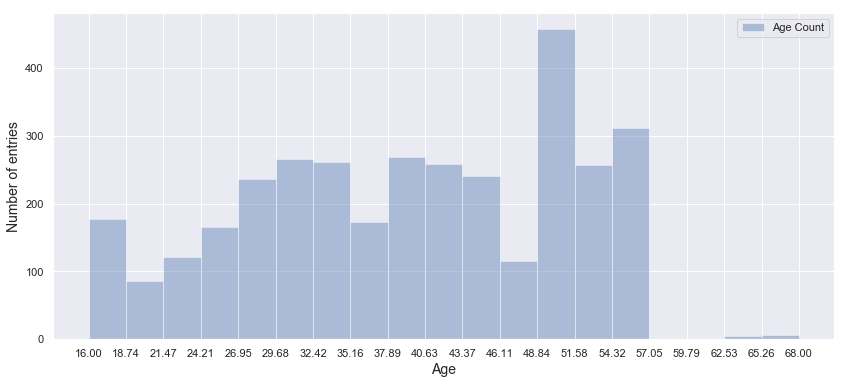

In [4]:
# Show the histogram
sns.set()

fig, ax = plt.subplots(figsize=(14, 6))

sns.distplot(ages, kde=False, ax=ax, label='Age Count')

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Number of entries', fontsize=14)

ax.set_xticks(e)

ax.legend()

plt.show()

Let's see its probability distribution, this done by setting the parameter <code>kde=True</code>, it will plot a gaussian kernel density estimate:

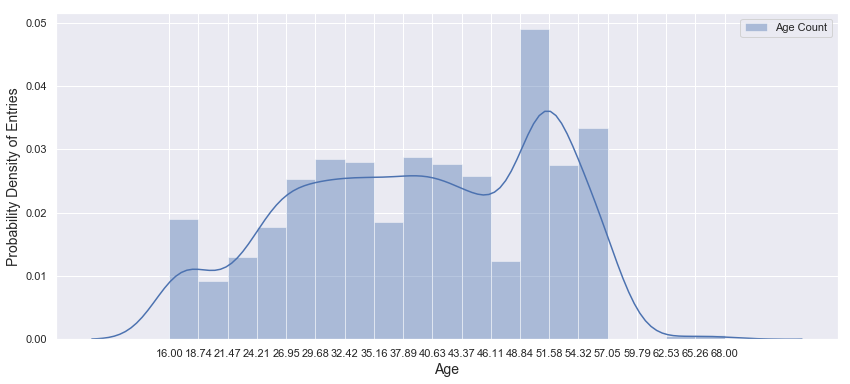

In [5]:
sns.set()

fig, ax = plt.subplots(figsize=(14, 6))

sns.distplot(ages, kde=True, ax=ax, label='Age Count')

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Probability Density of Entries', fontsize=14)

ax.set_xticks(e)

ax.legend()

plt.show()

The plots are telling us that the distribution is irregular and some regions have peaks surrounded by flatter areas. <b>A histogram is helpful when the queries are based on the probability of a sample to belong to a specific bin.</b>
<br>
<br>
Let's try to determine the probability of a person that has an age between $26.95$ and $29.68$. That range of age is found in the 4th bin starting from 0). As all the bins have the same width, we can <i>approximate</i> such a value with the ratio between $n_{p}(b_{4})$ as <cpde>h[4]</code> and $m$ as <code>ages.shape[0]</code>, let's remember the formula:
<br>
<br>
<div style='text-align:center; font-size:22px;'>
    $p(x_t) \approx \frac{1}{n} \frac{n_{p}(b_{t})}{w(b_{t})}$
</div>
<br>

In [6]:
# Number of Samples in the Ages dataset
n = float(ages.shape[0])
# Number of samples included into the bin  
np_bt = float(h[4])
# Width of the bin
w_bt = e[1] - e[0]

# Probability of sample X
p_xt = np_bt/(n*w_bt)

print('P(26.95 < x < 29.68) = {:.3f} ({:.3f}%)'.format(p_xt, p_xt * 100.0))

P(26.95 < x < 29.68) = 0.025 (2.529%)


The approximation of the probability is about $2.529\%$, this is also confirmed thanks to the structure of the histogram.
<br>
<br>
<b>But the Histogram method has the next limitations:</b>
<ul>
    <li>The most obvious one is that the number and the widths of the bins. A small number, yields rough results that 
        can't take into account the fast oscillations.</li>
    <li>A very large number drives to a holed histogram, because most of the bins will have no samples, <i>the outliers.</i>
    </li>
</ul>

A more robust approach is needed, due to all the possible novalties that are encountered in real-life cases. In the next part of this notebook we will work on how to improve the robustness of decting outliers.

<h2>Kernel Density Estimation (KDE)</h2>
<br>
The discontinuity of histograms is its bigger problem, this can be effectively solved with a simple method. For example: Given a data sample $x_i \in X$, it's possible to consider a hypervolume, assuming that we are dealing with multivariate distributions, whose center is $x_i$. The extension of such a region is defined through a constant $h$ called <b>bandwidth</b> (the <b>bandwidth</b> is a limited area where the value is positive). This solution works by counting the number of samples belonging to the hypervolume and this value is approximated by using a smooth kernel function $K(x_i; h)$ with some important features:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
    $K(\bar{x};h)\;is\;positive\;with\;K(\bar{x};h)\;=\;K(-x;h)$
</div>
<br>
There are several common choices for $K(\bullet)$, we are going to learn some of them before understanding the technique Kernel Density Estimation.
<br>
<h3>Gaussian Kernel</h3>
<br>
Its formula is:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
    $K(\bar{x};h)\;=\;\frac{1}{\sqrt[n]{2\pi h^2}}e^{-\frac{\bar{x}^T\bar{x}}{2h^2}}$
</div>
<br>
And it looks like this:
<br>
<div>
    <img src='images/1.png'>
</div>
<br>
A Gaussian kernel is one of the most common choice for density estimation tasks. A Gaussian distribution can be considered as an average reference for the kurtosis (which is proportional to the peak and to the heaviness of the tails, <i>this determines the outliers</i>).
<br>
<br>
To improve the selectiveness of the kernel, is needed to reduce the bandwidth. This means that even the smallest oscillations will alter the density and that the result is a very irregular estimation. On the other hand, $h$ represents the variance of the Gaussian distribution and when it is large, the approximation becomes very smooth and can lose the ability to capture all the peaks. For this reason, together with the selection of the most appropriate bandwidth, it's helpful to also consider other kernels that can naturally simplify the process.

<h3>Epanechnikov Kernel</h3>
<br>
This kernel intends to minimize the mean squared error ($MSE$), fortunately is very regular (Some people like to say that it can be imagined as inverted parabola). The formula is as follows:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
    $K(\bar{x};h)\;=\;\epsilon\Bigl(1 - \frac{x^2}{h^2}\Bigr)\;for\;|x|\;<\;1$
</div>
<br>
The constant $\epsilon$ is introduced to normalize the kernel and make possible to extend the kernel in range $(-h, h)$, this allows the kernel to be more consistent with the other functions. It's graphical representation is the next one:
<br>
<div>
    <img src='images/2.png'>
</div>
<br>
When $h\to0$ could become very peaked, but thanks to its mathematical structure always remain very regular; and in the majority of cases, there's no need to use it as a replacement of the Gaussian kernel (even if the latter has a slightly larger mean square error).
<br>
<br>
As the function is discontinuous at $x\;=\;±h(K(x; h)\;=\;0\;for\;|x|\;>\;h)$, it can cause rapid drops in the density estimation, in particular at the boundaries, where, for example, a Gaussian function decreases very gently.

<h3>Exponential Kernel</h3>
<br>
The king of peaked kernel? It could be the exponential one, it is a very peaked kernel, let's see its formula:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
    $K(\bar{x};h)\;=\;\epsilon e^{-\frac{|x|}{h}}$
</div>
<br>
This kernel has very heavy tails and a sharp peak, let's see it in a plot:
<br>
<div>
    <img src='images/3.png'>
</div>
<br>
<br>
This function is suitable to model very irregular distributions with a density highly concentrated around some specific points. Its tails are way more spreaded than most of the kernels, look at the range of them from $(-10, 0)$ and from $(0, 10)$, but the error can become very high when the data-generating process is quite regular with smooth surfaces. A good theoretical measure that can be employed to assess the performances of a kernel (and a bandwidth) is the mean integrated square error ($MISE$).

<h3>Uniform Kernel</h3>
<br>
The Uniform kernel is the simplest and less smooth kernel function, its usage resembles the standard procedure of building a histogram. Its formula is:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
    $K(\bar{x};h)\;=\;\frac{1}{2h}\;for\;|x|\;<\;h$
</div>
<br>
Clearly, it is a step that is constant in the range delimited by the bandwidth, and it's helpful only when the estimation doesn't need to be smooth, let's see its distribution:
<br>
<div>
    <img src='images/4.png'>
</div>
<br>

<h3>Estimating the Density</h3>
<br>
Once we have selected a kernel function, it's possible to build a probability density function for a complete approximation, we can do this through a k-nearest neighbors approach.
<br>
<br>
Given a dataset $X$ (for $X\;\in\; \mathbb{R}^m$, in this dataset the samples are real numbers), and by creating a ball-tree for partitioning the dataset in an efficient way. Once the ball-tree data structure is ready, we are able to obtain all the neighbors for a query point $x_j$, if they are inside a radius that is defined by the bandwidth.
<br>
<br>
Let's try to understand it with a example: If the set is $X_j = \{x_1, ..., x_t\}$ and the number of points is $N_j$. The estimation of the probability density is obtained as follows:
<br>
<br>
<div style='text-align:center;font-size:22px;'>
    $p_{K}(x_{j}) = \frac{1}{N_{j}h}\;\sum\limits_{t}K\Bigl(\frac{x_{j}-x_{t}}{h};h\Bigr)$
</div>
<br>
We can prove that if the bandwidth is chosen in the most adequate manner as a function of the number of samples that are in the neighborhood, $p_K$ will converge in probability to the actual $p(x)$. This means: if the granularity (dimensionality of a set) is large enough, the absolute error between the approximation and the true density converges to zero. Let's see the building process for $p_{K}(x_j)$ in the next diagram:
<br>
<div>
    <img src='images/5.png'>
</div>
<br>
In the image above we can see how the density estimatio of $x_j$ is done, the Kernel functions are evaluated in each data sample that belong to the neighborhood (radius $h$) of $x_j$.
<br>
<br>
We based the queries on a <code>k-NN</code> approach because is easier to interpolated through a local behavior due that the far data sample won't have any influence on the estimation and this avoids having contributions that are quite close to zero.
<br>
<h4>Coding an Example</h4>
<br>
<br>
We are going to use <code>scikit-learn</code> to show the density estimation for the defined dataset of <code>ages</code>. At this point we don't have any specific prior knowledge of the density of the dataset, we are going to perfrom a Gaussian kernel with several bandwidths ($0.1$, $0.5$, and $1.5$).
<br>
<br>
The parameter of  , related to metric must be changed because the default metric cannot be adequate for all tasks .
<br>
<br>
Let's go! We first must instantiate the classes and fitting the models:

In [7]:
# Instantiate the classes
kd_01 = KernelDensity(kernel='gaussian', bandwidth=0.1)
kd_05 = KernelDensity(kernel='gaussian', bandwidth=0.5)
kd_15 = KernelDensity(kernel='gaussian', bandwidth=1.5)

In [8]:
# Train KDE with Gaussian kernels and 3 bandwidths
kd_01.fit(ages.reshape(-1, 1))
kd_05.fit(ages.reshape(-1, 1))
kd_15.fit(ages.reshape(-1, 1))

KernelDensity(algorithm='auto', atol=0, bandwidth=1.5, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

Now we are able to invoke the <code>score_samples()</code> method, it will return <i><b>log-density</b></i> estimation for a set of data samples,  the dataset we are dealing with have a range of $(10, 70)$ with $0.05$ increments. The values are $log(p)$, this obligate us to compute $e^{log(p)}$ to get the actual probabilities.
<br>
<br>
<b>Let's see the results:</b>

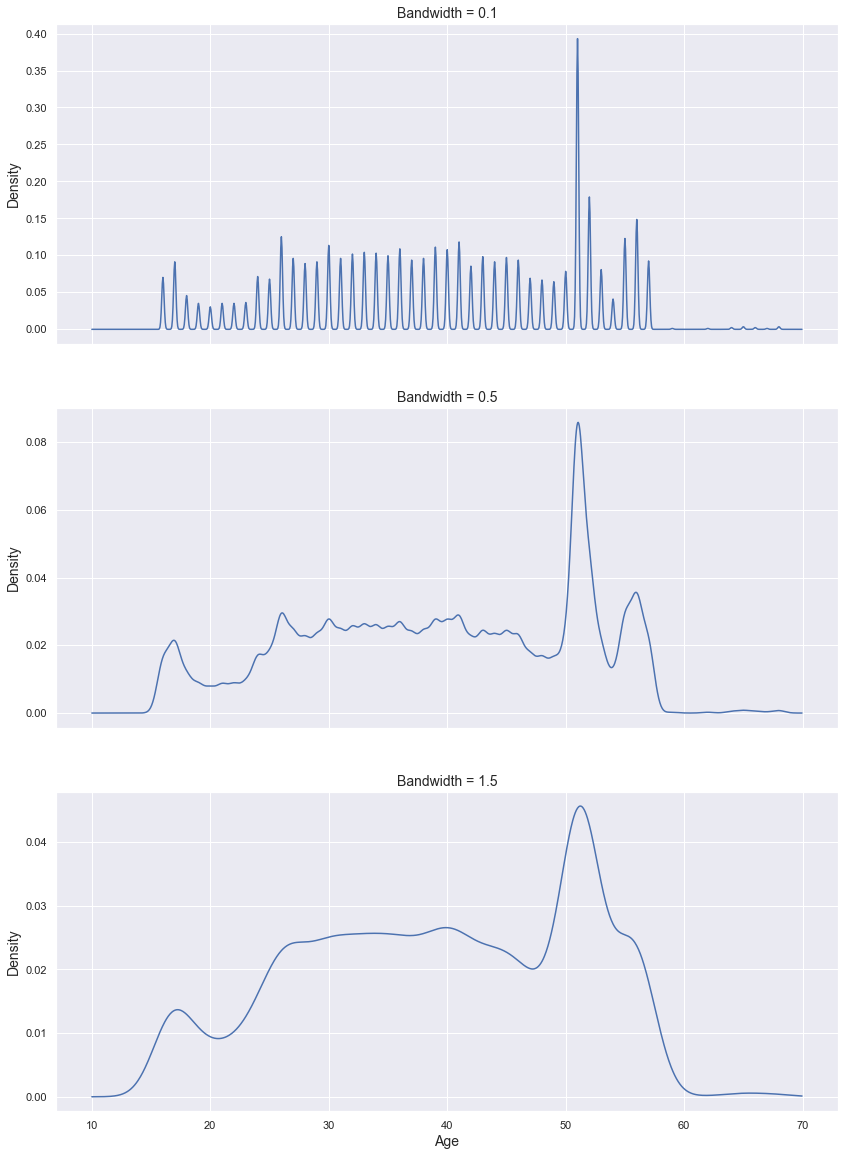

In [9]:
sns.set()

fig, ax = plt.subplots(3, 1, figsize=(14, 20), sharex=True)

data = np.arange(10, 70, 0.05).reshape(-1, 1)

ax[0].plot(data, np.exp(kd_01.score_samples(data)))
ax[0].set_title('Bandwidth = 0.1', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)

ax[1].plot(data, np.exp(kd_05.score_samples(data)))
ax[1].set_title('Bandwidth = 0.5', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)

ax[2].plot(data, np.exp(kd_15.score_samples(data)))
ax[2].set_title('Bandwidth = 1.5', fontsize=14)
ax[2].set_xlabel('Age', fontsize=14)
ax[2].set_ylabel('Density', fontsize=14)

plt.show()

We can see that when the bandwidth is has the value of $0.1$, the density is affected by having more frequent oscillations due to the few samples for sthe pecific sub-ranges (<i>lack of samples for the certain width</i>).
<br>
<br>
When the bandwith has the value of  $0.5$, the contour (as the dataset is univariate) becomes more stable, even though there are still some residual variations due to by the internal variance of the neighbors.
<br>
<br>
The internal variances, the fast shifts of variations are almost gone when the bandwidth has the value of $1.5$.
<br>
<h2>Selection criteria with Bandwidth</h2>
<br>
<b>How can we determine the most appropriate bandwidth?</b> A great way to determine the most adequate bandwith is the value of $h$ that minimizes the $MISE$, but this method can only be applied when the true probability density is known. Luckily, there are empiric criterias that have been confirmed to be very trustworthy. Given a complete dataset $X\;\in\; \mathbb{R}^m$, the first criteria is based on the following formula:
<br>
<br>
<div style='text-align:center; font-size:22px'>
    $h = 1.06 \bullet std(X) \bullet m^{-0.2}$
</div>
<br>
Let's apply this formula to obtain the most adequate bandwith according to the formula:

In [10]:
m = float(ages.shape[0])
h = 1.06 * np.std(ages) * np.power(m, -0.2)
print('Bandwidth (h): {:.4f}'.format(h))

Bandwidth (h): 2.4152


According to the first criteria, we should increase the value of $h$ from  $1.5$ to $2.4152$.
<br>
<br>
The second reliable criteria is based on the <b>IQR</b>, ($IQR = Q_{3}-Q_{1} = 75^{th}_{percentile} - 25^{th}_{percentile})$, this criteria is more robust to strong internal variations, and it is calculated by applying the following formula:
<br>
<br>
<div style='text-align:center; font-size:22px'>
    $h = 0.9 \bullet min\Bigl(std(X), \frac{IQR}{1.34} \Bigr) \bullet m^{-0.2}$
</div>
<br>
And its pythonic formula is:

In [11]:
m = float(ages.shape[0])
IQR = np.percentile(ages, 75) - np.percentile(ages, 25)
h = 0.9 * np.min([np.std(ages), (IQR/1.34)]) * np.power(m, -0.2)

print('Bandwidth (h): {:.4f}'.format(h))

Bandwidth (h): 2.0506


This value of $h$ obtained by the second criteria differs in being smaller than the previous one, a value of $2.0506$ for $h$ indicates that $p_{K}(x)$ can be more accurate with smaller hypervolumes, smaller granularity.
<br>
<br>
<b>What value for $h$ should we use?</b> A rule of thumb, is selecting the method that returns the smallest bandwidth.
<br>
<br>
Let's now calculate the density estimation, using $h = 2.0506$ and the Gaussian, Epanechnikov, and Exponential kernels, (the Uniform kernel is being excluded because the final result is equivalent to a histogram):

In [12]:
# Instantiate the classes
kd_gaussian = KernelDensity(kernel='gaussian', bandwidth=h)
kd_epanechnikov = KernelDensity(kernel='epanechnikov', bandwidth=h)
kd_exponential = KernelDensity(kernel='exponential', bandwidth=h)

In [13]:
# Train KDE with Gaussian kernels and 3 bandwidths
kd_gaussian.fit(ages.reshape(-1, 1))
kd_epanechnikov.fit(ages.reshape(-1, 1))
kd_exponential.fit(ages.reshape(-1, 1))

KernelDensity(algorithm='auto', atol=0, bandwidth=2.0506291954095035,
              breadth_first=True, kernel='exponential', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

Let's see the results

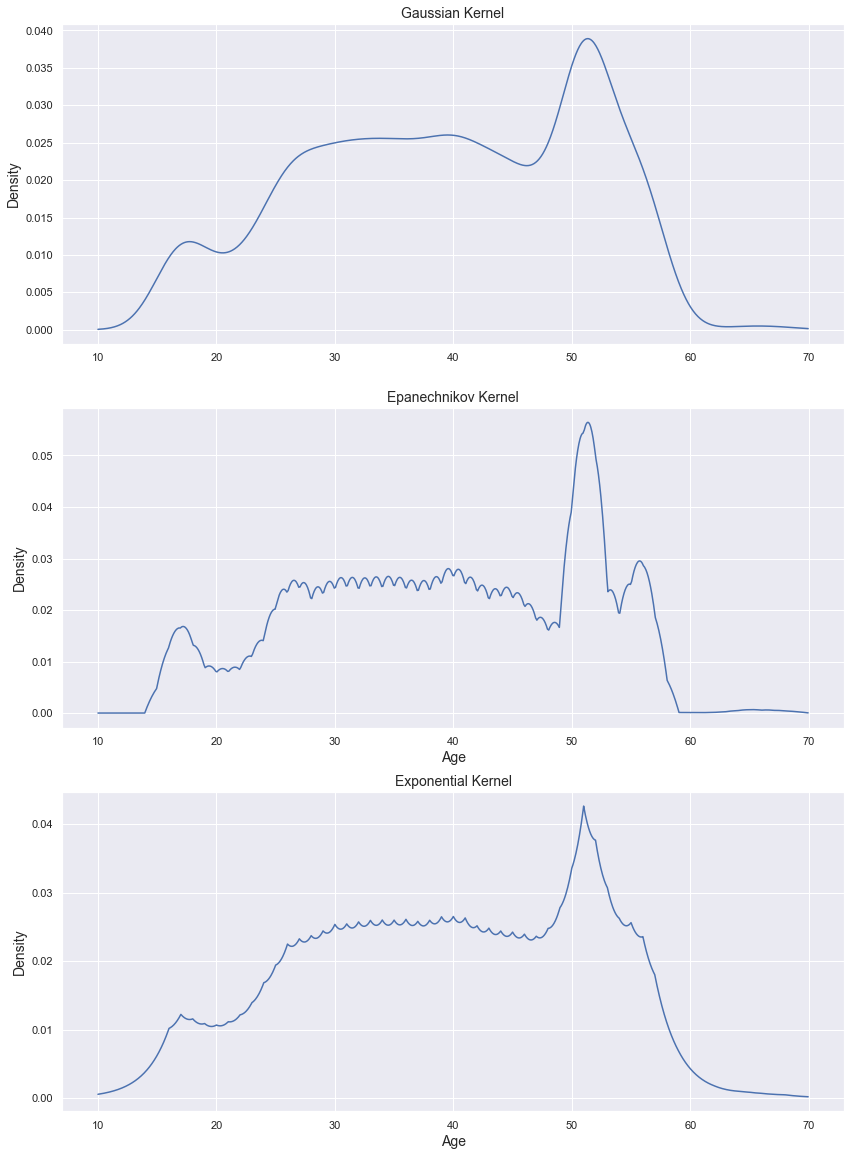

In [14]:
fig, ax = plt.subplots(3, 1, figsize=(14, 20), sharex=False)

data = np.arange(10, 70, 0.05).reshape(-1, 1)

ax[0].plot(data, np.exp(kd_gaussian.score_samples(data)))
ax[0].set_title('Gaussian Kernel', fontsize=14)
ax[0].set_ylabel('Density', fontsize=14)

ax[1].plot(data, np.exp(kd_epanechnikov.score_samples(data)))
ax[1].set_title('Epanechnikov Kernel', fontsize=14)
ax[1].set_ylabel('Density', fontsize=14)
ax[1].set_xlabel('Age', fontsize=14)

ax[2].plot(data, np.exp(kd_exponential.score_samples(data)))
ax[2].set_title('Exponential Kernel', fontsize=14)
ax[2].set_xlabel('Age', fontsize=14)
ax[2].set_ylabel('Density', fontsize=14)

plt.show()

The Epanechnikov and Exponential kernels have more oscillations than the Gaussian one, this happens because they tend to be more peaked when $h$ is small.
<br>
<br>
The Epanechnikov plot is surely the most accurate (in terms of MISE). A Epanechnikov kernel has a very strong discontinuous trend when the value reaches the boundaries of the bandwidth. This phenomenon can be immediately understood by looking at the extremes of the estimation, which drops almost vertically to zero.
<br>
<br>
In the following section, we are going to apply the Epanechnikov kernel.

<h2>Univariate Anomaly Detection</h2>
<br>
We are going to employ the Epanechnikov density estimation to perform an example of Univariate Anomaly Detection. According to the structure of the probability density, we have decided to impose a threshold of $p(x) < 0.005$. The threshold is displayed in the following screenshot:
<br>
<img>
    <img src='images/6.png'>
</img>
<br>
The age limits is indicate by the red dots, for a sample to be classified as an anomaly if its probability density is smaller than $0.05$. Let's compute the probability densities for some test points:

In [15]:
test_data = np.array(np.arange(0, 105, 5)).reshape(-1, 1)

test_densities_epanechnikov = np.exp(kd_epanechnikov.score_samples(test_data))
test_densities_gaussian = np.exp(kd_gaussian.score_samples(test_data))

for age, density in zip(np.squeeze(test_data), test_densities_epanechnikov):
    print('p(Age = {:d}) = {:.7f} ({})'.format(age, density, 'Anomaly' if density < 0.005 else 'Normal'))

p(Age = 0) = 0.0000000 (Anomaly)
p(Age = 5) = 0.0000000 (Anomaly)
p(Age = 10) = 0.0000000 (Anomaly)
p(Age = 15) = 0.0053130 (Normal)
p(Age = 20) = 0.0080545 (Normal)
p(Age = 25) = 0.0205458 (Normal)
p(Age = 30) = 0.0243363 (Normal)
p(Age = 35) = 0.0247974 (Normal)
p(Age = 40) = 0.0267012 (Normal)
p(Age = 45) = 0.0225666 (Normal)
p(Age = 50) = 0.0402486 (Normal)
p(Age = 55) = 0.0252794 (Normal)
p(Age = 60) = 0.0000870 (Anomaly)
p(Age = 65) = 0.0006540 (Anomaly)
p(Age = 70) = 0.0000157 (Anomaly)
p(Age = 75) = 0.0000000 (Anomaly)
p(Age = 80) = 0.0000000 (Anomaly)
p(Age = 85) = 0.0000000 (Anomaly)
p(Age = 90) = 0.0000000 (Anomaly)
p(Age = 95) = 0.0000000 (Anomaly)
p(Age = 100) = 0.0000000 (Anomaly)


A person aged 15 is almost at the boundary ($p(15) ≈ 0.0049$), while the behavior is even more drastic for the upper bound. The threshold cut-off seems to start at 58 years of age. A sample aged 60 is about 10 times less likely than a one aged 57 (this is also confirmed by the initial histogram).
<br>
<br>
We can also say that the ages with a probability density of $0$ are novelties, relative outliers from exterior data.
<br>
<br>
It was easy to detect outliers because we were dealing with a didactive example, however, even a slightly more complex distribution could create a few problems without a standardized algorithm. In this case, we were detecting outlier from an univariate distribution, the anomalies are usually located in the tails in an univariate distribution.
<br>
<br>
We must be careful when defining a threshold, for this it is good to learn the normal distribution by removing all anomalies from the dataset, even the flatten ($pK(x) → 0$), these are the regions where the anomalies are usually located. Applying this criteria makes easy to compare different densities to make a distinction.

<h2>Anomaly Detection with HTTP Attacks</h2>
<br>
The data that we are going to work the KDD Cup 99 dataset. This dataset is made of long collections of series of normal and malicious internet activities. We are going to focus on the subset of HTTP requests, which has following four attributes:
<ul>
    <li>Duration.</li>
    <li>Source Bytes.</li>
    <li>Destination Bytes.</li>
    <li>Behavior: It has information that makes it be similar to a 
        classification dependent feature, it lets us have access to 
        a certain kind of attacks.</li>
</ul>
The original values were small numbers, around zero, the version from <code>scikit-learn</code> needs a renormalization of the variables, this will be done by using the formula $log(x + 0.1)$ (<i>This formula must be apply when simulating the anomaly detection with new samples</i>). The inverse transformation is as follows:
<br>
<br>
<div style='text-align:center; font-size:22px'>
    $y = log(x+0.1) \implies x = e^y - 0.1$
</div>
<br>
We are going to start by loading and <i>preparing</i> the dataset using the <code>scikit-learn</code> built-in function </code>fetch_kddcup99() and selecting <code>percent10=True</code> therefore we will be limiting the data to 10% of the original collection, we also select the <code>subset='http'</code>, this subset has been already prepared to contain a very larger number of normal connections and a few specific attacks and as in a standard periodical log 

In [17]:
kddcup99 = fetch_kddcup99(subset='http', percent10=True, random_state=1000)

In [105]:
X = kddcup99['data'].astype(np.float64)
Y = kddcup99['target']

print('Statuses: {}'.format(np.unique(Y)))
print('Normal samples: {}'.format(X[Y == b'normal.'].shape[0]))
print('Anomalies: {}'.format(X[Y != b'normal.'].shape[0]))

Statuses: [b'back.' b'ipsweep.' b'normal.' b'phf.' b'satan.']
Normal samples: 56516
Anomalies: 2209


There are four types of attacks with $2209$ malicious samples and $56516$ normal connections.
<br>
<br>
We are going to perform a density estimation, but first we must consider the three components as independent random variables (is not completely realistic, but it can be a reasonable starting point) for some preliminary consideration, but the final estimation is based on the full joint distribution.
<br>
<br>
We have to determine an optimal bandwidth, let's perform a basic statistical analysis. We are going to determine the optiman bandwith with the second criteria:

In [106]:
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)
IQRs = np.percentile(X, 75, axis=0) - np.percentile(X, 25, axis=0)

print('Mean: {}'.format(means))
print('STD:  {}'.format(stds))
print('IQRs: {}'.format(IQRs))

Mean: [-2.26381954  5.73573107  7.53879208]
STD:  [0.49261436 1.06024947 1.32979463]
IQRs: [0.         0.34871118 1.99673381]


The IQR for first component is null, the name of this component or feature is <code>Duration</code>; this means that the majority of values are equal. Let's plot a histogram to confirm this:

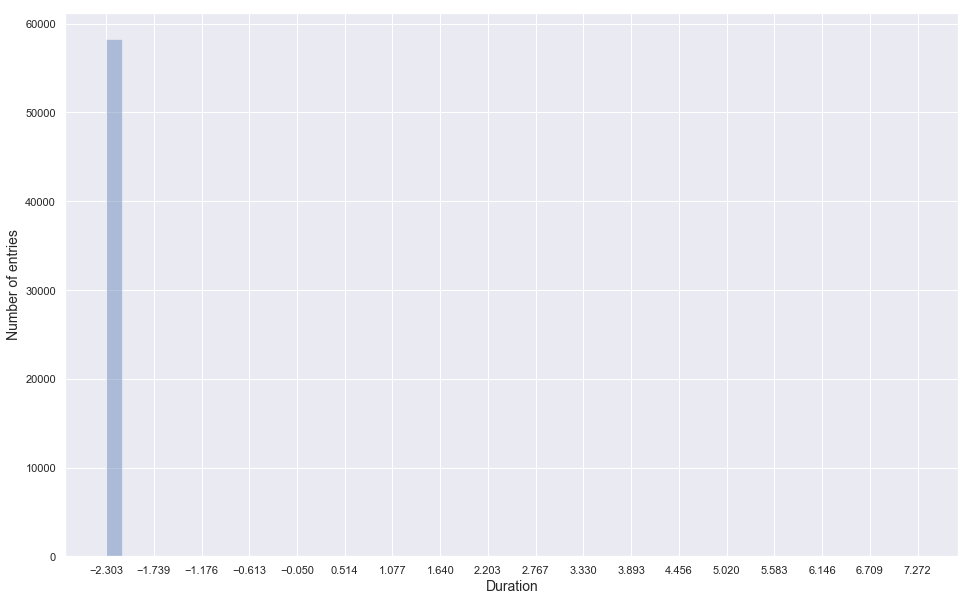

In [107]:
h0, e0 = np.histogram(X[:, 0], bins='auto')

sns.set()

fig, ax = plt.subplots(figsize=(16, 10))

sns.distplot(X[:, 0], kde=False, ax=ax)

ax.set_xlabel('Duration', fontsize=14)
ax.set_ylabel('Number of entries', fontsize=14)

ax.set_xticks(e0)

plt.show()

The feature <code>Duration</code> is not very significant, <b>Why?</b> <i>because only a small percentage of the samples have different values.</i>
We are going to drop it out from the dataset and work only with the features of <code>Source</code> and <code>Destination bytes</code>. Let's now compute the bandwidth as explained previously:

In [108]:
# Compute the optimal bandwidth
N = float(X.shape[0])

h0 = 0.9 * np.min([stds[0], IQRs[0] / 1.34]) * np.power(N, -0.2)
h1 = 0.9 * np.min([stds[1], IQRs[1] / 1.34]) * np.power(N, -0.2)
h2 = 0.9 * np.min([stds[2], IQRs[2] / 1.34]) * np.power(N, -0.2)

print('h0 = {:.3f}, h1 = {:.3f}, h2 = {:.3f}'.format(h0, h1, h2))

h0 = 0.000, h1 = 0.026, h2 = 0.133


We will exclude the <code>h0</code> bandwidth, as its made of the values from the feature <code>Destination</code> ands its has a few variation, the bandwidth for this feature is almost null, we will to choose between <code>h1</code> and <code>h2</code>.
<br>
<br>
As the magnitude of the values is not large and we need to be quite selective, we are going to setv<code>h = 0.025</code> and apply a Gaussian kernel, which it is intended to provide a good smoothness.

In [109]:
# Set bandwidth h to h1
h = 0.025

Let's see the <code>KDE</code> for normal and malicious connections:

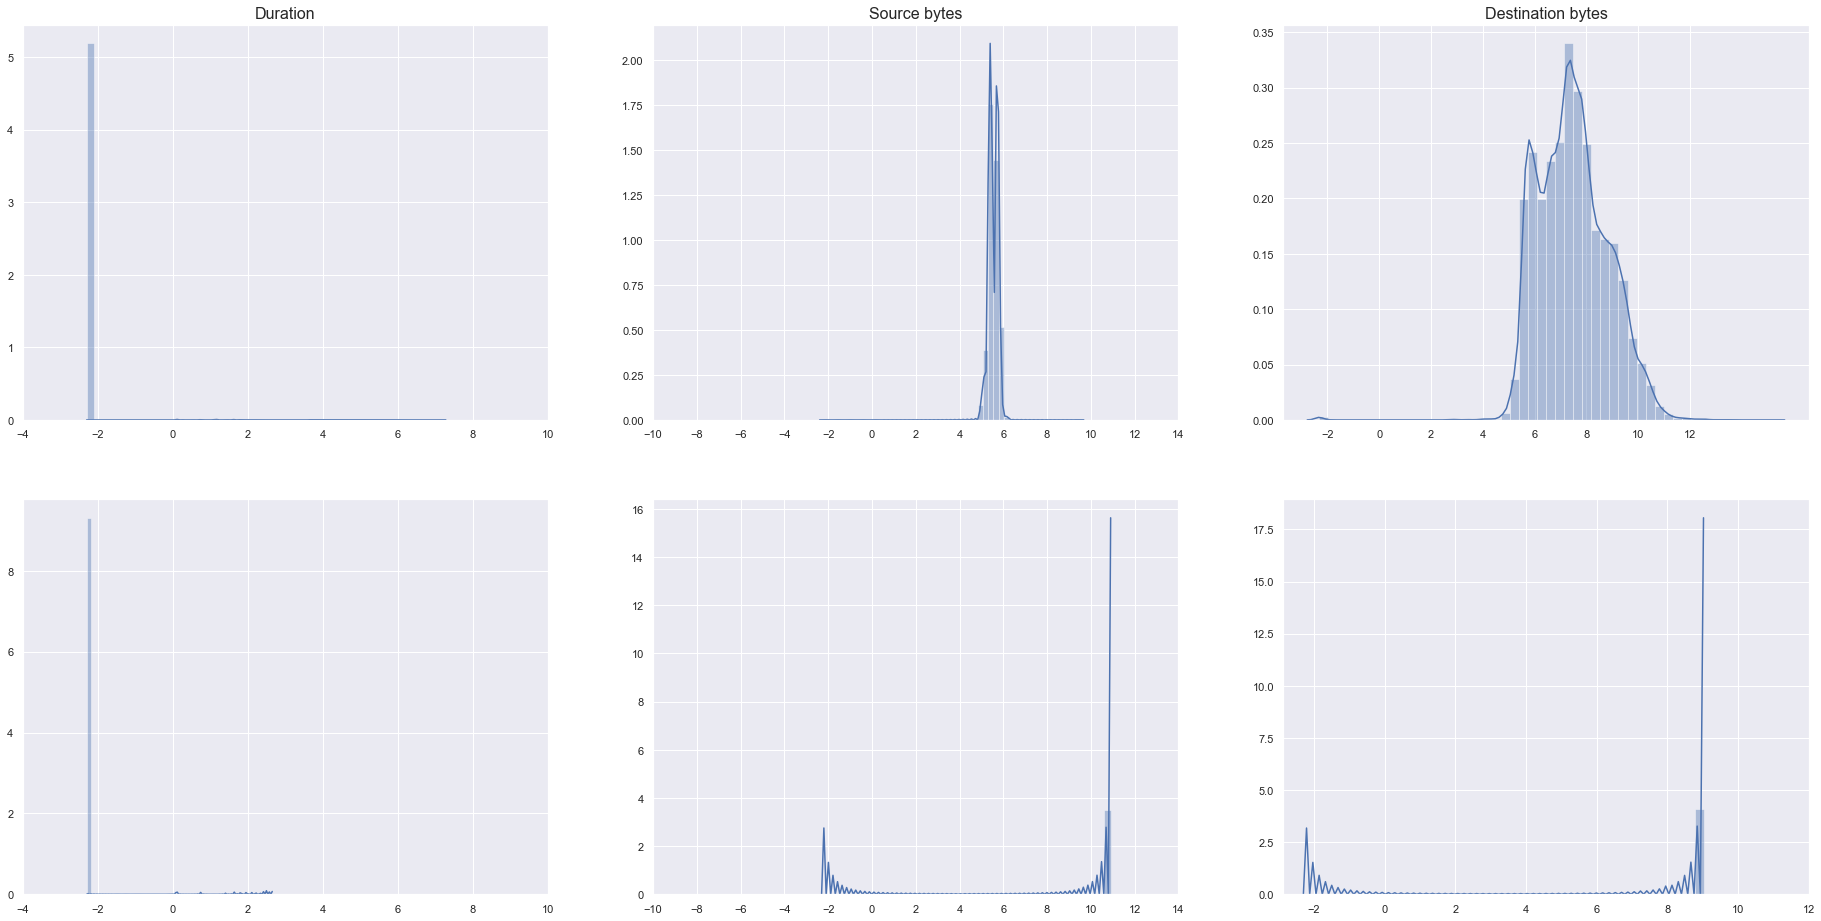

In [110]:
fig, ax = plt.subplots(2, 3, figsize=(32, 16))

sns.distplot(X[Y == b'normal.', 0], kde=True, ax=ax[0, 0], label='KDE')
sns.distplot(X[Y == b'normal.', 1], kde=True, ax=ax[0, 1], label='KDE')
sns.distplot(X[Y == b'normal.', 2], kde=True, ax=ax[0, 2], label='KDE')

sns.distplot(X[Y != b'normal.', 0], kde=True, ax=ax[1, 0], label='KDE')
sns.distplot(X[Y != b'normal.', 1], kde=True, ax=ax[1, 1], label='KDE')
sns.distplot(X[Y != b'normal.', 2], kde=True, ax=ax[1, 2], label='KDE')

ax[0, 0].set_title('Duration', fontsize=16)
ax[0, 1].set_title('Source bytes', fontsize=16)
ax[0, 2].set_title('Destination bytes', fontsize=16)

ax[0, 0].set_xticks(np.arange(-4, 12, 2))
ax[1, 0].set_xticks(np.arange(-4, 12, 2))

ax[0, 1].set_xticks(np.arange(-10, 16, 2))
ax[1, 1].set_xticks(np.arange(-10, 16, 2))

ax[0, 2].set_xticks(np.arange(-2, 14, 2))
ax[1, 2].set_xticks(np.arange(-2, 14, 2))

plt.show()

The first rows shows the densities for normal connections, while the second one it shoes malicious attacks. The first component/feature <code>duration</code> is almost identical in both cases, and it must be discarded.
<br>
<br>
The <code>Source</code> and <code>Destination</code> features/components are  exhibiting very different behaviors. <i>Without considering the logarithmic transformation</i>, we can see that normal connections are sent on average of $5$ bytes with a very low variance that extends the potential range to the interval $(4, 6)$.
<br>
<br>
The responses are characterized by a larger variance, with values between 4 and 10 and a low density starting from $10$.
<br>
<br>
<code>Source</code> and <code>Destination</code> features/components bytes for malicious attacks are characterized by two peaks:
<ul>
    <li>A shorter peak corresponding to $-2$.</li>
    <li>A taller one orresponding, from $11$ and $9$; with a minimum overlap 
        with the normal regions.</li>
</ul>
It's not hard to understand that the most of the attacks send more input data and receive longer responses, while the connection duration is less affected.

Let's train the estimator by selecting only the normal data samples, this is done by <code>[Y == b'normal.']</code>

In [111]:
# Exclude de dependent variable
X = X[:, 1:]
# Perform the KDE
kd = KernelDensity(kernel='gaussian', bandwidth=h)
# Train the estimator
kd.fit(X[Y == b'normal.'])

KernelDensity(algorithm='auto', atol=0, bandwidth=0.025, breadth_first=True,
              kernel='gaussian', leaf_size=40, metric='euclidean',
              metric_params=None, rtol=0)

Let's compute the densities for both normal and anomaly samples:

In [112]:
Yn = np.exp(kd.score_samples(X[Y == b'normal.']))
Ya = np.exp(kd.score_samples(X[Y != b'normal.']))

In [113]:
print('Mean normal: {:.5f} - Std: {:.5f}'.format(np.mean(Yn), np.std(Yn)))
print('Mean anomalies: {:.5f} - Std: {:.5f}'.format(np.mean(Ya), np.std(Ya)))

Mean normal: 0.39588 - Std: 0.25755
Mean anomalies: 0.00008 - Std: 0.00374


We can expect an anomaly when, for example, $p_{K}(x) < 0.05$; if we consider three standard deviations. For an anomaly, we obtain $p_{K}(x) ∈ (0, 0.01)$, while the median of $Yn$ is arround $0.35$. This means that at least half of the samples have $p_{K}(x) > 0.35$. However, after a simple count check, we obtain this:

In [114]:
print(np.sum(Yn < 0.05))
print(np.sum(Yn < 0.04))
print(np.sum(Yn < 0.03))
print(np.sum(Yn < 0.02))
print(np.sum(Yn < 0.015))
print(np.sum(Ya < 0.015))

3147
2459
1778
1037
702
2208


The dataset is composed of 56516 normal samples, we can decide to pick two thresholds, to consider also the anomaly outliers:
<ul>
    <li><b>Normal Connection:</b> $p_{k}(x) > 0.03$.</li>
    <li><b>Medium Alert:</b> $0.03$, it involves $3.1\%$ of normal samples 
        that could be identified as false positives.</li>
    <li><b>High Alert:</b> $0.015$, only $1.12\%$ of normal samples can 
        activate the alarm.</li>
</ul>

Only an anomaly sample has $p_K(x) > 0.015$, there are a total of 2,209 vectors, which confirms that such a choice is reasonable.
<br>
<br>
Let's create a function that checks the status of a connection according to the amount of source and destination bytes (<i>not logarithmic</i>):

In [116]:
def is_anomaly(kd, source, destination, medium_thr=0.03, high_thr=0.015):
    xs = np.log(source + 0.1)
    xd = np.log(destination + 0.1)
    data = np.array([[xs, xd]])

    density = np.exp(kd.score_samples(data))[0]

    if density >= medium_thr:
        return density, 'Normal connection'
    elif density >= high_thr:
        return density, 'Medium risk'
    else:
        return density, 'High risk'

Let's test it:

In [117]:
print('p = {:.2f} - {}'.format(*is_anomaly(kd, 200, 1100)))
print('p = {:.2f} - {}'.format(*is_anomaly(kd, 360, 200)))
print('p = {:.2f} - {}'.format(*is_anomaly(kd, 800, 1800)))

p = 0.30 - Normal connection
p = 0.02 - Medium risk
p = 0.00 - High risk


Great! We have a function that works for detecting attacks according a certain thresholds.
<br>
<br>
Let's display a bivariate plot of the source and destination bytes densities

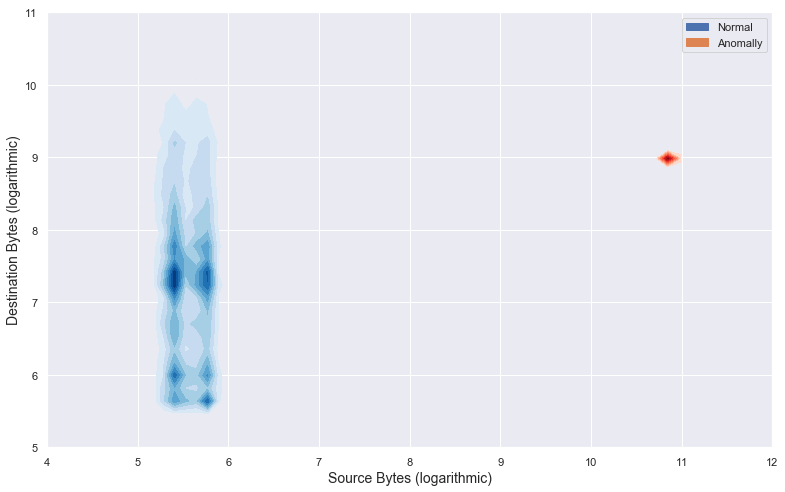

In [123]:
fig, ax = plt.subplots(figsize=(13, 8))

sns.kdeplot(X[Y != b'normal.', 0], X[Y != b'normal.', 1], cmap="Reds", shade=True, shade_lowest=False, kernel='epa',
                bw=0.025, ax=ax, label='Normal')
sns.kdeplot(X[Y == b'normal.', 0], X[Y == b'normal.', 1], cmap="Blues", shade=True, shade_lowest=False,
                kernel='epa', bw=0.025, ax=ax, label='Anomally')

ax.set_xlabel('Source Bytes (logarithmic)', fontsize=14)
ax.set_ylabel('Destination Bytes (logarithmic)', fontsize=14)

ax.set_xlim(4, 12)
ax.set_ylim(5, 11)

ax.legend()

plt.show()

The Bivariate plot, confirms that the attacks normally have a larger amount of input bytes and the responses are similar to normal ones, even when they occupy an extreme part of the region.
<br>
<br>
In the next part we are going to learn about One-Class Support Vector Machines.

<h2>One-Class Support Vector Machines</h2>
<br>
Is a method that was proposed to classify the novelties either as samples drawn from the true data-generating process or as outliers. 
<br>
<br>
We are trying to perform anomaly detection through an unsupervised model that, given a data sample $x_i$, will yield a binary output $y_i$, therefore, if $x_i$ is an inlier it will yield $y_i$ to be $+1$ and conversely $y_i$ to be $-1$ if $x_i$ is an outlier, the authors of this variation of SVC assume that the outcome is $1$ for the most of the inliers, which constitute the training set.
<br>
<br>
This is not a classical supervised problem; however, it isn't because it doesn't require a labeled dataset. In fact, if a dataset $X$ containing $m$ samples $x_i \in \mathbb{R}^n$, the model will have to be trained using a single class and it will try to find a separating hyperplane that maximizes the distance between $X$ and the origin. Let's take a look at the following diagram:
<br>
<div>
    <img src='images/7.png'>
</div>
<br>
The image above tells us that the training set is separated from the origin with the largest margin.
<br>
<br>
The model have to be trained in order to find out the parameters of the hyperplane that will maxmimize the distance from the origin. In on side of the hyperplane all the data sample will be expected to be inliers with an output label of $+1$, while all the remaining data samples are in the other side being considered as outliers with an output label of $-1$. This criterion is only acceptable for linearly separable datasets.
<br>
<br>
<div style='text-align:center; font-size:22px;'>
    $\phi(\bar{x_i}) : X \to D$
</div>
<br>
Due to the mathematical nature of the problem, the projection becomes easy to compute, <i>if a kernel is chosen.</i> The decision function it is define as follows:
<br>
<br>
<div style='text-align:center; font-size:22px;'>
    $y_{i} = sign(\bar{w}\cdot\phi(\bar{x_i}) - \rho )$
</div>
<br>
The result from the dot product operation between the weight vector $(\bar{w})$ and the projection of a sample $\phi(\bar{x_i})$ determines the position of $x_i$ with in relation to the separating hyperplane.
<br>
<h3>The Hyperparameter $\upsilon$</h3> 
<br>
The hyperparameter $\upsilon \in (0,1)$, when $\rho \neq 0, \upsilon$ can be understood and used as an upper bound of the fraction of training samples, which are outliers. The use of \upsilon and \xi <i>(slack variables)</i> allows us to deal better when a dataset has a small fraction of outliers. This can be interpreted if $X$ has been drawn from a data-generating process that is partially corrupted by noise, this noise will generate outliers in $X$ and $\upsilon$ will work as the probability to find an outlier in $X$.
<br>
<h3>One Class SVM Code Example</h3>  
<br>
We are going to analyze a bidimensional dataset example based on a population  identified with a tuple (age, height). Let's generate 2,000 inliers drawn from a bivariate Gaussian distribution and 200 test points uniformly sampled

In [154]:
nb_samples = 2000
nb_test_samples = 200

X = np.empty(shape=(nb_samples + nb_test_samples, 2))

X[:nb_samples] = np.random.multivariate_normal([15, 160], np.diag([1.5, 10]), size=nb_samples)
X[nb_samples:, 0] = np.random.uniform(11, 19, size=nb_test_samples)
X[nb_samples:, 1] = np.random.uniform(120, 210, size=nb_test_samples)

We have created a dataset with different scales, let's standarized the dataset before training the model

In [156]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

Let's plot the standardized dataset

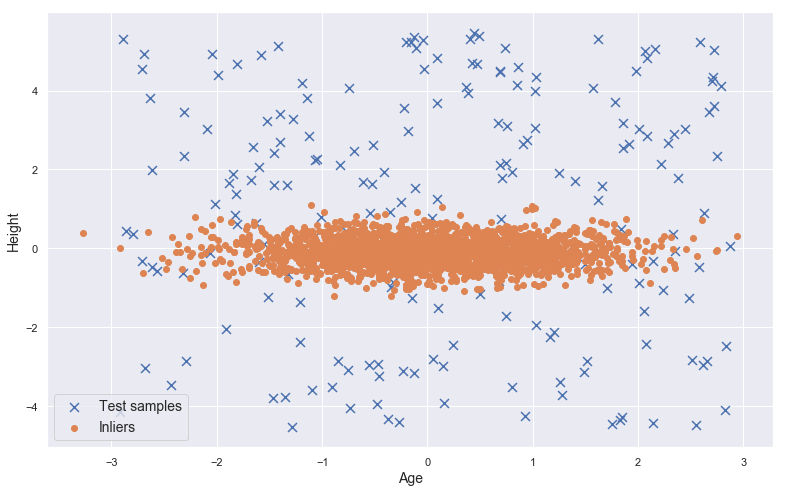

In [177]:
sns.set()

fig, ax = plt.subplots(figsize=(13, 8))

ax.scatter(Xs[nb_samples:, 0], Xs[nb_samples:, 1], marker='x', s=80, label='Test samples')
ax.scatter(Xs[:nb_samples, 0], Xs[:nb_samples, 1], marker='o', label='Inliers')

ax.set_xlabel('Age', fontsize=14)
ax.set_ylabel('Height', fontsize=14)

ax.legend(fontsize=14)

plt.show()

The main blob (the red cluster) is mainly compose of inliers and a part of the test samples are in the same highly-dense region and due to this insight we can reasonably suppose to have about $20\%$ of outliers in the dataset containing all the samples, this could be express as $\upsilon = 0.2$.
<br>
<br>
Such an empirical choice is based on a visual assumption and in any real-life scenario, the value for $\upsilon$ must always be corresponded and reflected to the actual percentage of expected outliers in the dataset. But in our made up scenario the information of the porcentage of outliers in the dataset is not available, when that happens it's preferable to start from a larger value; for example, $\upsilon=0.5$ and to proceed by decreasing it until the optimal configuration has been foundth, and that optimal value will be the minimum probability of misclassification.
<br>
<br>
Let's now create and initialize an instance of <code>OneClassSVM</code> class from <code>scikit-learn</code> library using an RBF kernel, which is particularly designed and suitable for Gaussian data-generating processes, the hyperparameter $\upsilon$ is identified with the parameter <code>nu</code>.

In [187]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.2)

Time to train

In [188]:
Ys = ocsvm.fit_predict(Xs)

That was fast, cool! Let's see the results

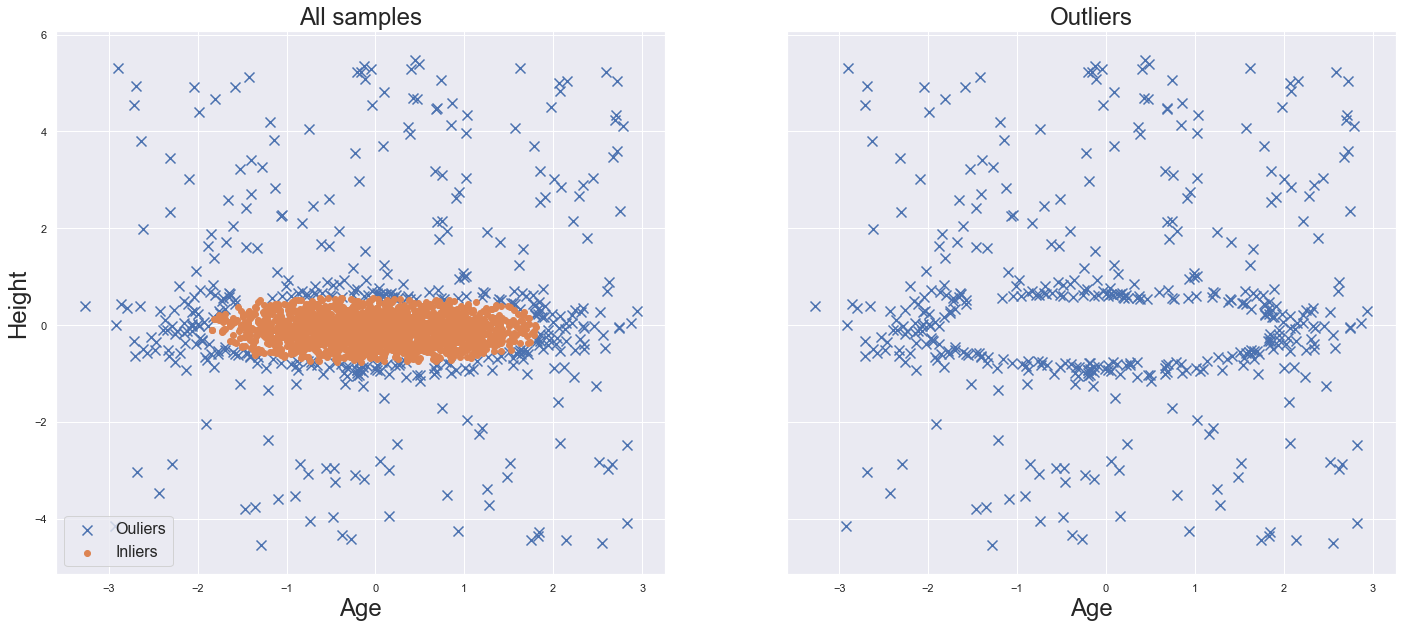

In [189]:
fig, ax = plt.subplots(1, 2, figsize=(24, 10), sharey=True)

ax[0].scatter(Xs[Ys == -1, 0], Xs[Ys == -1, 1], marker='x', s=100, label='Ouliers')
ax[0].scatter(Xs[Ys == 1, 0], Xs[Ys == 1, 1], marker='o', label='Inliers')

ax[1].scatter(Xs[Ys == -1, 0], Xs[Ys == -1, 1], marker='x', s=100)

ax[0].set_xlabel('Age', fontsize=24)
ax[0].set_ylabel('Height', fontsize=24)

ax[1].set_xlabel('Age', fontsize=24)

ax[0].set_title('All samples', fontsize=24)
ax[1].set_title('Outliers', fontsize=24)

ax[0].legend(fontsize=16)

plt.show()

In the left diagram, the model has successfully identified the higher-density part of the dataset and it has also marked as outliers some samples in the outer region of the dense blob. They correspond to values with a low probability under the bivariate Gaussian and, in our case, we have assumed that they are noisy samples that should be categorized as outliers.
<br>
<br>
In the right diagram, we only plot the outlier region, it is the complement of the high-density blob.
<br>
<br>
One-Class SVM, it is a little bit prone to overfit but is able to identify novelties with a small error probability. Of course this is also due to the structure of the dataset, but with high-dimensional data, this simplicity is usually lost because of the often need of performing dimensionality reductions techniques and a thorough hyperparameter optmization search is necessary to obtained an acceptable error rate.

In [125]:
!git add .
!git commit -m "Section One Class Support Vector Machines Has Been Started"
!git push -u origin master

The file will have its original line endings in your working directory
The file will have its original line endings in your working directory


[master 03398cf] Section One Class Support Vector Machines Has Been Started
 8 files changed, 1938 insertions(+), 178 deletions(-)
 create mode 100644 images/1.png
 create mode 100644 images/2.png
 create mode 100644 images/3.png
 create mode 100644 images/4.png
 create mode 100644 images/5.png
 create mode 100644 images/6.png
Branch 'master' set up to track remote branch 'master' from 'origin'.


To https://github.com/kleyersoma/Anomaly_Detection_with_Unsupervised_Learning.git
   ff37e10..03398cf  master -> master
